## SVM

`Overview`: SVM constructs a hyperplane or set of hyperplanes in a high-dimensional space to separate different classes. It aims to maximize the margin between these classes, enhancing the model's generalization capabilities.

In this notebook a combination of `Recursive Feature Elimination` (RFE) and `Support Vector Machine` (SVM) classification is created for our predictions. It leverages Optuna to optimize hyperparameters and feature selection, ensuring the model is both robust and interpretable.

The features are standardized using `StandardScaler` to normalize their distributions. This step is critical for SVM, as it relies on distance-based computations, which can be skewed by differences in feature scales.

A custom metric, `specificity`, is defined to measure the ability of the model to correctly classify non-playoff teams. This is a crucial metric for imbalanced datasets where one class might dominate.

RFE is used to identify the most important features for predicting playoff outcomes. It iteratively removes the least important features based on the model's coefficients, selecting a subset that maximizes model performance. The number of features to retain is treated as a hyperparameter and optimized via Optuna.

`Optuna` is utilized to optimize the following hyperparameters:
- C: The regularization strength of the SVM. Smaller values indicate stronger regularization, while larger values allow the model to fit the training data more closely.
- Max Iterations: The maximum number of iterations for the SVM solver to converge.
- Number of Features to Select: The number of features retained by RFE.

Optuna performs 100 trials to maximize accuracy, returning the best hyperparameters and their corresponding score.

The `SVM` model is initialized with the `optimal regularization strength` (C) and `maximum iterations` (max_iter).

RFE is applied to select the optimal number of features, identified by the hyperparameter `n_features_to_select`.

The final model is trained on the reduced feature set, and the coefficients of the trained model are used to rank the features by their importance.

The final model is evaluated using 10-fold stratified cross-validation across multiple metrics: Accuracy, Precision, Recall, F1 Score, ROC AUC and Specificity.

[I 2024-12-20 21:17:01,558] A new study created in memory with name: SVM with RFE Optimization
[I 2024-12-20 21:17:01,674] Trial 0 finished with value: 0.7457142857142857 and parameters: {'C': 0.2772749530205287, 'max_iter': 6120, 'n_features_to_select': 7}. Best is trial 0 with value: 0.7457142857142857.
[I 2024-12-20 21:17:01,702] Trial 1 finished with value: 0.6971428571428571 and parameters: {'C': 0.00016923526502327457, 'max_iter': 9180, 'n_features_to_select': 38}. Best is trial 0 with value: 0.7457142857142857.
[I 2024-12-20 21:17:01,724] Trial 2 finished with value: 0.6904761904761905 and parameters: {'C': 0.0004447436772425473, 'max_iter': 4748, 'n_features_to_select': 40}. Best is trial 0 with value: 0.7457142857142857.
C:\Users\gonca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warning


Best parameters:
{'C': 0.2761748617596542, 'max_iter': 2566, 'n_features_to_select': 13}
Best cross-validated accuracy from Optuna: 0.8295
Selected Features: ['Rank', 'PlayoffProgScore', 'W', 'FTA', 'DREB', 'AST', 'TOV', 'PFD', 'AST/TO', 'REB%', 'CumulativePlayoffProgScore', 'AvgPIE_NextYearPlayers', 'Performance_NextYearCoach']

Feature Importance After RFE:
                       Feature  Coefficient  Absolute Importance
1             PlayoffProgScore     0.709553             0.709553
0                         Rank     0.686066             0.686066
11      AvgPIE_NextYearPlayers     0.518151             0.518151
3                          FTA    -0.458251             0.458251
2                            W     0.450333             0.450333
8                       AST/TO     0.409469             0.409469
9                         REB%     0.403826             0.403826
5                          AST    -0.398270             0.398270
12   Performance_NextYearCoach    -0.377793         

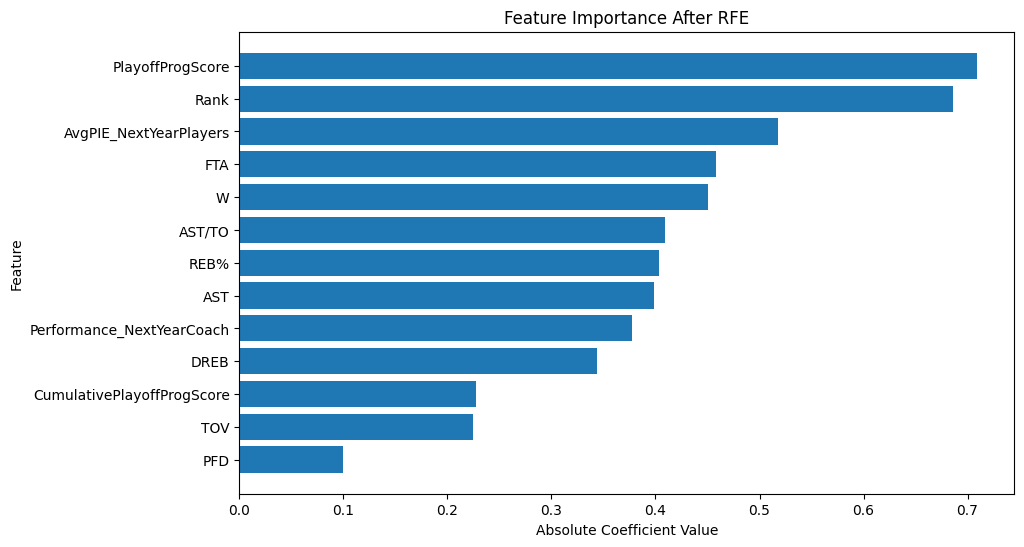


Evaluation metrics for the final model:
Accuracy - Mean: 0.8295, Std: 0.0808
Precision - Mean: 0.8385, Std: 0.1222
Recall - Mean: 0.8446, Std: 0.0774
F1 - Mean: 0.8350, Std: 0.0718
Roc_auc - Mean: 0.8788, Std: 0.0876
Specificity - Mean: 0.8143, Std: 0.1571

Final cross-validated accuracy (with best params): 0.8295


C:\Users\gonca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\gonca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\gonca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\User

In [10]:
import pandas as pd
import numpy as np
import optuna
from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, make_scorer, roc_curve, auc
import matplotlib.pyplot as plt

# Load the dataset
dataset = pd.read_csv('../../cleaned_data/dataset.csv')

# Prepare features and label data
label = 'PlayoffNextSeason'
features = [col for col in dataset.columns if col != label]

X = dataset[features]
y = dataset[label]

# Handle missing values
X = X.fillna(X.mean())

# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return tn / (tn + fp)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define the objective function for Optuna with RFE
def objective(trial):
    # Suggest hyperparameters for SVM
    C = trial.suggest_float('C', 0.0001, 1000, log=True)
    max_iter = trial.suggest_int('max_iter', 100, 10000)

    n_features_to_select = trial.suggest_int('n_features_to_select', 1, len(features))

    # Create the SVM model (LinearSVC)
    base_model = LinearSVC(C=C, dual=True, max_iter=max_iter, random_state=42)

    # Perform RFE for feature selection
    rfe = RFE(estimator=base_model, n_features_to_select=n_features_to_select)
    X_selected = rfe.fit_transform(X, y)

    # Perform stratified k-fold cross-validation on selected features
    cv_scores = cross_val_score(base_model, X_selected, y, cv=skf, scoring='accuracy', error_score='raise')

    # Return the mean accuracy as the objective value
    return np.mean(cv_scores)

# Create an Optuna study and optimize
study = optuna.create_study(direction='maximize', study_name="SVM with RFE Optimization")
study.optimize(objective, n_trials=100)

# Display the best parameters
print("\nBest parameters:")
print(study.best_params)
print(f"Best cross-validated accuracy from Optuna: {study.best_value:.4f}")

# Retrieve best parameters
best_params = study.best_params
best_model = LinearSVC(
    C=best_params['C'],
    max_iter=best_params['max_iter'],
    random_state=42
)

# Perform RFE with the best number of features
rfe = RFE(estimator=best_model, n_features_to_select=best_params['n_features_to_select'])
X_selected = rfe.fit_transform(X, y)
selected_features = [features[i] for i in range(len(features)) if rfe.support_[i]]
print(f"Selected Features: {selected_features}")

# Train the final model on selected features
best_model.fit(X_selected, y)

# Get feature importance (coefficients)
coefficients = best_model.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': coefficients,
    'Absolute Importance': np.abs(coefficients)
}).sort_values(by='Absolute Importance', ascending=False)

print("\nFeature Importance After RFE:")
print(feature_importance)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Absolute Importance'])
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.title('Feature Importance After RFE')
plt.gca().invert_yaxis()
plt.show()

# Evaluate the final model on multiple metrics with fixed random state for CV
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'specificity': make_scorer(specificity_score)
}

final_skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_results = cross_validate(best_model, X_selected, y, cv=final_skf, scoring=scoring)

# Print results
print("\nEvaluation metrics for the final model:")
for metric in scoring.keys():
    scores = cv_results[f'test_{metric}']
    print(f"{metric.capitalize()} - Mean: {np.mean(scores):.4f}, Std: {np.std(scores):.4f}")

# For direct comparison, print the final accuracy again using the same CV as in the objective
final_cv_scores = cross_val_score(best_model, X_selected, y, cv=final_skf, scoring='accuracy')
print(f"\nFinal cross-validated accuracy (with best params): {np.mean(final_cv_scores):.4f}")


C:\Users\gonca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\gonca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\gonca\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\User

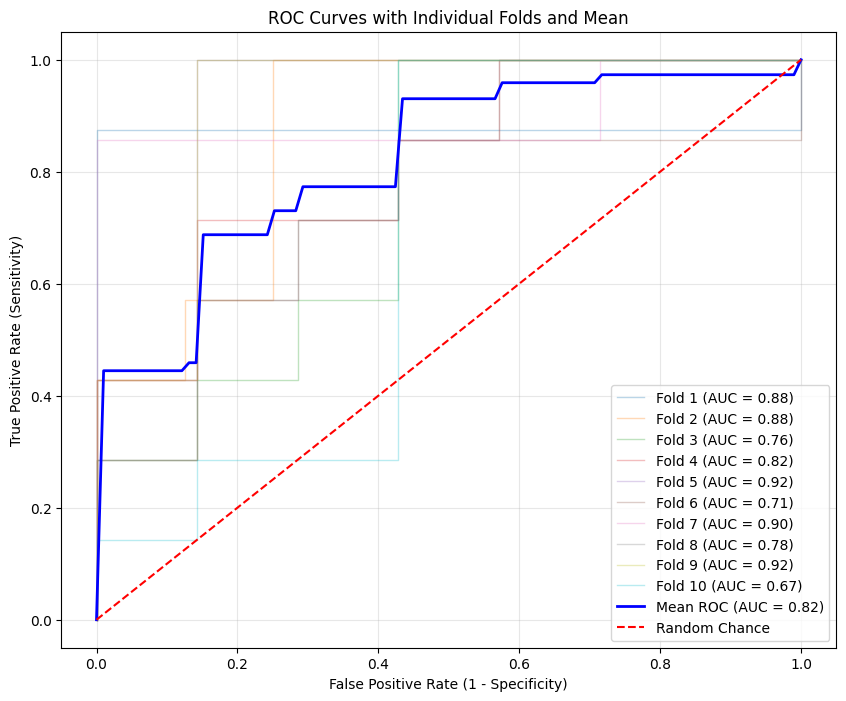

In [11]:
decision_function = best_model.decision_function(X_selected)

plt.figure(figsize=(10, 8))
# Compute ROC curve data
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []

# Perform stratified k-fold cross-validation
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    # Using NumPy indexing to access training and testing sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model
    best_model.fit(X_train, y_train)

    # Get decision function scores
    decision_function = best_model.decision_function(X_test)

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, decision_function)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0

    # Plot ROC curve for this fold
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')


# Compute mean TPR and AUC
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)

# Plot mean ROC curve
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC (AUC = {mean_auc:.2f})', lw=2)

# Plot the random chance line
plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Random Chance')

plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curves with Individual Folds and Mean')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


The `Mean AUC` (Area Under Curve) is 0.82, which indicates good overall performance. This model is better than random guessing and shows a reasonably strong ability to distinguish between classes.

The `AUC` values for individual folds range from 0.67 (worst-performing fold) to 0.92 (best-performing folds in Fold 5 and Fold 9).

The relatively wide range of `AUC` values (0.67–0.92) suggests some variability in model performance across different folds. This could be due to the dataset's properties, including differences in feature distribution between folds.

The curve is closer to the top-left corner for most folds, which indicates good sensitivity (True Positive Rate) at a low False Positive Rate.

However, some folds (Fold 10 with AUC = 0.67) show weaker performance, likely reflecting some difficulty in separating the classes in that fold.

While the `Mean AUC` of 0.82 is quite good, improvements could be made by addressing the variability.
